### Configure environment

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,ashusri_0000051121
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


### Define configuration for this experiment

In [2]:
slice_name="bbr-trace-validation-" + fablib.get_bastion_username()
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)
     

#slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


In [3]:
n_senders = 10
n_receivers = 1

In [4]:
exp_requires = {'core': (n_senders+n_receivers)*4 + 4, 'nic': (n_senders + n_receivers + 1)*1}
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_requires['core']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_requires['nic'])  ):
        break

fablib.show_site(site_name)

Name,PRIN
State,Active
Address,"151, Forrestal Road, Plainsboro Township, Middlesex County, New Jersey, 08537"
Location,"(40.34612015, -74.61607299655245)"
PTP Capable,True
Hosts,3
CPUs,6
Cores Available,295
Cores Capacity,384
Cores Allocated,89
RAM Available,1026


'<pandas.io.formats.style.Styler object at 0x7a3ec4179030>'

In [4]:
# this cell sets up the hosts
slice.add_node(name='router', site=site_name, cores=4, ram=32, disk=100, image='default_ubuntu_22')

sender_names = ["sender-"+str(i) for i in range(n_senders)]
for n in sender_names:
    slice.add_node(name=n, site=site_name, cores=4, ram=32, disk=100, image='default_ubuntu_22')  

receiver_names = ["receiver-"+str(i) for i in range(n_receivers)]
for n in receiver_names:
    slice.add_node(name=n, site=site_name, cores=4, ram=32, disk=100, image='default_ubuntu_22')  



In [5]:
# this cell sets up the network links
nets = [
    {"name": "link-sender",    "nodes": sender_names,  "idx": 0},
    {"name": "link-receiver",  "nodes": receiver_names, "idx": 1}
]

router_iface = []
router_iface.append(slice.get_node('router').add_component(model="NIC_Basic", name='link-sender').get_interfaces()[0])
router_iface.append(slice.get_node('router').add_component(model="NIC_Basic", name='link-receiver').get_interfaces()[0])
print(router_iface)



[<fabrictestbed_extensions.fablib.interface.Interface object at 0x7f5081fb5de0>, <fabrictestbed_extensions.fablib.interface.Interface object at 0x7f5081fb7340>]


In [6]:
for n in nets:
    ifaces = [slice.get_node(node).add_component(model="NIC_Basic", name=n["name"]).get_interfaces()[0] for node in n['nodes'] ] + [router_iface[n["idx"]]]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)


In [7]:
slice.submit(wait_timeout=5000)


Retry: 18, Time: 1006 sec


ID,c5087ece-468d-47ad-9abf-f345ae5b2eb3
Name,bbr-trace-validation-ashusri_0000051121
Lease Expiration (UTC),2024-05-02 20:03:50 +0000
Lease Start (UTC),2024-05-01 20:03:52 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
f437357e-bfb0-4562-9ff8-51add9dc46c3,receiver-0,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe53:a83f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe53:a83f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
afe65210-14e4-46ba-bd72-8c3c55e772e5,router,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe73:27e2,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe73:27e2,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
d3645788-6890-4574-8be5-4460e5a45a2a,sender-0,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe67:38cb,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe67:38cb,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
5f2861fd-92d7-4d66-856c-6303a527c797,sender-1,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:feb4:bdbb,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feb4:bdbb,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
d5fea363-911b-451a-831a-417fb43808f3,sender-2,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:feaa:b754,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feaa:b754,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2c71e772-7783-4bf9-9db5-934e5ca143be,sender-3,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe87:6044,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe87:6044,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2aa35e89-8727-4b99-b053-9980f9a425f5,sender-4,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fede:283c,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fede:283c,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
83e4da5d-c814-4146-8371-ede7463cf412,sender-5,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:feab:b3eb,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feab:b3eb,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c951f549-d1bf-417c-8bc3-3c5e13f40337,sender-6,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fec2:5140,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fec2:5140,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
403e7751-e99f-49f5-98a9-eb7f3df53e35,sender-7,4,32,100,default_ubuntu_22,qcow2,rutg-w4.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe29:dd98,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe29:dd98,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric

ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
4f86c3b6-1acb-40d8-8db0-b0c9d8726af5,link-receiver,L2,L2Bridge,RUTG,None,None,Active,
26a6f15e-fb75-4da0-8404-886993503338,link-sender,L2,L2Bridge,RUTG,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
router-link-sender-p1,p1,router,link-sender,100,config,,1E:9D:E1:A5:19:D9,enp7s0,enp7s0,None,4
router-link-receiver-p1,p1,router,link-receiver,100,config,,1E:E9:8A:1A:86:FC,enp8s0,enp8s0,None,4
sender-0-link-sender-p1,p1,sender-0,link-sender,100,config,,22:5B:A5:D0:3E:3D,enp7s0,enp7s0,None,4
sender-1-link-sender-p1,p1,sender-1,link-sender,100,config,,26:86:A8:9C:1F:3A,enp7s0,enp7s0,None,4
sender-2-link-sender-p1,p1,sender-2,link-sender,100,config,,26:D2:8B:10:33:4A,enp7s0,enp7s0,None,4
sender-3-link-sender-p1,p1,sender-3,link-sender,100,config,,2E:7A:59:B3:AA:30,enp7s0,enp7s0,None,4
sender-4-link-sender-p1,p1,sender-4,link-sender,100,config,,2E:80:D8:C5:19:03,enp7s0,enp7s0,None,4
sender-5-link-sender-p1,p1,sender-5,link-sender,100,config,,2E:A6:FE:7A:07:1F,enp7s0,enp7s0,None,4
sender-6-link-sender-p1,p1,sender-6,link-sender,100,config,,2E:12:2D:BD:CE:78,enp7s0,enp7s0,None,4
sender-7-link-sender-p1,p1,sender-7,link-sender,100,config,,32:07:50:38:43:8A,enp7s0,enp7s0,None,4



Time to print interfaces 1024 seconds


'c5087ece-468d-47ad-9abf-f345ae5b2eb3'

In [4]:
slice.get_state()

'StableOK'

In [5]:
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

## Install BBRv2 kernel

In [64]:
pkg_list = ['linux-headers-5.13.12_5.13.12-2_amd64.deb',
            'linux-libc-dev_5.13.12-2_amd64.deb',
            'linux-image-5.13.12_5.13.12-2_amd64.deb']

cmd_BBRv2 ="""sudo grub-set-default "Advanced options for Ubuntu>Ubuntu, with Linux 5.13.12"
sudo grub-mkconfig -o /boot/grub/grub.cfg
sudo sed -i 's/^GRUB_DEFAULT=.*/GRUB_DEFAULT=saved/' /etc/default/grub
sudo update-grub
sudo reboot"""

for n in sender_nodes:
    for pkg in pkg_list:
        n.execute("wget https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/{packet}".format(packet=pkg))
    n.execute("sudo dpkg -i  *.deb")
    n.execute(cmd_BBRv2)


 --2024-05-01 22:39:10--  https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/linux-headers-5.13.12_5.13.12-2_amd64.deb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8347652 (8.0M) [application/octet-stream]
Saving to: ‘linux-headers-5.13.12_5.13.12-2_amd64.deb.1’

     0K .......... .......... .......... .......... ..........  0% 22.5M 0s
    50K .......... .......... .......... .......... ..........  1% 22.8M 0s
   100K .......... .......... .......... .......... ..........  1% 22.9M 0s
   150K .......... .......... .......... .......... ..........  2%  143M 0s
   200K .......... .......... .......... .......... ..........  3% 97.1M 0s
   250K .......... .......... .......... .......... ..........  3% 37.3M 0s
   300K ......

In [31]:
pkg_list = ['linux-headers-5.13.12_5.13.12-2_amd64.deb',
            'linux-libc-dev_5.13.12-2_amd64.deb',
            'linux-image-5.13.12_5.13.12-2_amd64.deb']

cmd_BBRv2 ="""sudo grub-set-default "Advanced options for Ubuntu>Ubuntu, with Linux 5.13.12"
sudo grub-mkconfig -o /boot/grub/grub.cfg
sudo sed -i 's/^GRUB_DEFAULT=.*/GRUB_DEFAULT=saved/' /etc/default/grub
sudo update-grub
sudo reboot"""

for n in receiver_nodes:
    for pkg in pkg_list:
        n.execute("wget https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/{packet}".format(packet=pkg))
    n.execute("sudo dpkg -i  *.deb")
    n.execute(cmd_BBRv2)

 --2024-05-06 16:11:31--  https://raw.githubusercontent.com/sdatta97/imcbbrrepro/main/setup/linux-headers-5.13.12_5.13.12-2_amd64.deb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8347652 (8.0M) [application/octet-stream]
Saving to: ‘linux-headers-5.13.12_5.13.12-2_amd64.deb’

     0K .......... .......... .......... .......... ..........  0% 24.7M 0s
    50K .......... .......... .......... .......... ..........  1% 25.2M 0s
   100K .......... .......... .......... .......... ..........  1% 21.5M 0s
   150K .......... .......... .......... .......... ..........  2% 30.7M 0s
   200K .......... .......... .......... .......... ..........  3% 85.4M 0s
   250K .......... .......... .......... .......... ..........  3%  175M 0s
   300K ........

In [32]:
for n in sender_nodes:
    n.execute("uname -a")

for n in receiver_nodes:
    n.execute("uname -a")

Linux sender-0 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-1 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-2 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-3 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-4 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-5 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-6 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-7 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-8 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux sender-9 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
Linux receiver-0 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


In [10]:
for n in sender_nodes:
    n.execute("sudo modprobe tcp_bbr2")

## Configure resources

In [11]:
slice = fablib.get_slice(name=slice_name)

Bring up all of the network interfaces:

In [37]:
for iface in slice.get_interfaces():
    iface.ip_link_up()

Assign addresses to router interfaces and enable forwarding:

In [24]:
from ipaddress import ip_address, IPv4Address, IPv4Network

if_sender = slice.get_interface('router-link-sender-p1')
if_sender.ip_addr_add(addr="10.10.1.1", subnet=IPv4Network("10.10.1.0/24"))
if_receive = slice.get_interface('router-link-receiver-p1')
if_receive.ip_addr_add(addr="10.10.2.1", subnet=IPv4Network("10.10.2.0/24"))

slice.get_node(name='router').execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1


('net.ipv4.ip_forward = 1\n', '')

Assign addresses to host (sender and receiver) interfaces and set up routes:

In [38]:
for i in range(n_senders):
    if_name = slice.get_interface('sender-' + str(i) + '-link-sender-p1')
    if_name.ip_addr_add(addr="10.10.1.1" + str(i) , subnet=IPv4Network("10.10.1.0/24"))
    slice.get_node(name='sender-' + str(i)).ip_route_add(subnet=IPv4Network("10.10.2.0/24"), gateway="10.10.1.1")
    
for i in range(n_receivers):
    if_name = slice.get_interface('receiver-' + str(i) + '-link-receiver-p1')
    if_name.ip_addr_add(addr="10.10.2.1" + str(i) , subnet=IPv4Network("10.10.2.0/24"))
    slice.get_node(name='receiver-' + str(i)).ip_route_add(subnet=IPv4Network("10.10.1.0/24"), gateway="10.10.2.1")

In [26]:
# turn off segmentation offload on interfaces
for iface in slice.get_interfaces():
    iface_name = iface.get_device_name()
    n = iface.get_node()
    offloads = ["gro", "lro", "gso", "tso"]
    for offload in offloads:
        n.execute("sudo ethtool -K %s %s off" % (iface_name, offload))

Also install `iperf3` on sender and receiver hosts:

In [6]:
sender_nodes = [slice.get_node(name='sender-' + str(i))  for i in range(n_senders)]
receiver_nodes = [slice.get_node(name='receiver-' + str(i))  for i in range(n_receivers)]

In [24]:
from ipaddress import ip_address, IPv6Address
for n in sender_nodes:
    n.execute("sudo apt update; sudo apt -y install iperf3; sudo apt -y install python3; sudo modprobe tcp_bbr")
    n.execute_thread("sudo modprobe tcp_bbr")
              
for n in receiver_nodes:
    n.execute_thread("sudo apt update; sudo apt -y install iperf3")
    


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
 

 Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists...
Building dependency tree...
Reading state information...
99 packages can be upgraded. Run 'apt list --upgradable' to see them.
 

 Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libiperf0 libsctp1
Suggested packages:
  lksctp-tools
The following NEW packages will be installed:
  iperf3 libiperf0 libsctp1
0 upgraded, 3 newly installed, 0 to remove and 99 not upgraded.
Need to get 106 kB of archives.
After this operation, 346 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu jammy/main amd64 libsctp1 amd64 1.0.19+dfsg-1build1 [9370 B]
Get:2 http://no

In [98]:
for n in sender_nodes:
    n.execute("sudo apt -y install python3")

Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Building dependency tree...
Reading state information...
python3 is already the newest version (3.10.6-1~22.04).
python3 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.
Reading package lists... 

 
Bui

In [12]:
for n in sender_nodes:
    n.execute("iperf3 -version")

iperf 3.9 (cJSON 1.7.13)
Linux sender-0 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication
iperf 3.9 (cJSON 1.7.13)
Linux sender-1 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication
iperf 3.9 (cJSON 1.7.13)
Linux sender-2 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication
iperf 3.9 (cJSON 1.7.13)
Linux sender-3 5.13.12 #2 SMP Mon Aug 28 19:18:51 UTC 2023 x86_64
Optional features available: CPU affinity setting, IPv6 flow label, SCTP, TCP congestion algorithm setting, sendfile / zerocopy, socket pacing, authentication


In [26]:
for n in sender_nodes:
    n.execute("sudo apt-get update; sudo apt-get install -y python3-pip ethtool netcat moreutils ",quiet=True)
    n.execute("sudo python3 -m pip install scikit-learn numpy pandas matplotlib seaborn", quiet=True)
    
for n in receiver_nodes:
    n.execute("sudo apt-get update; sudo apt-get install -y python3-pip ethtool netcat moreutils ",quiet=True)
    n.execute("sudo python3 -m pip install scikit-learn numpy pandas matplotlib seaborn", quiet=True)

## Draw the network topology 

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [12]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
all_nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

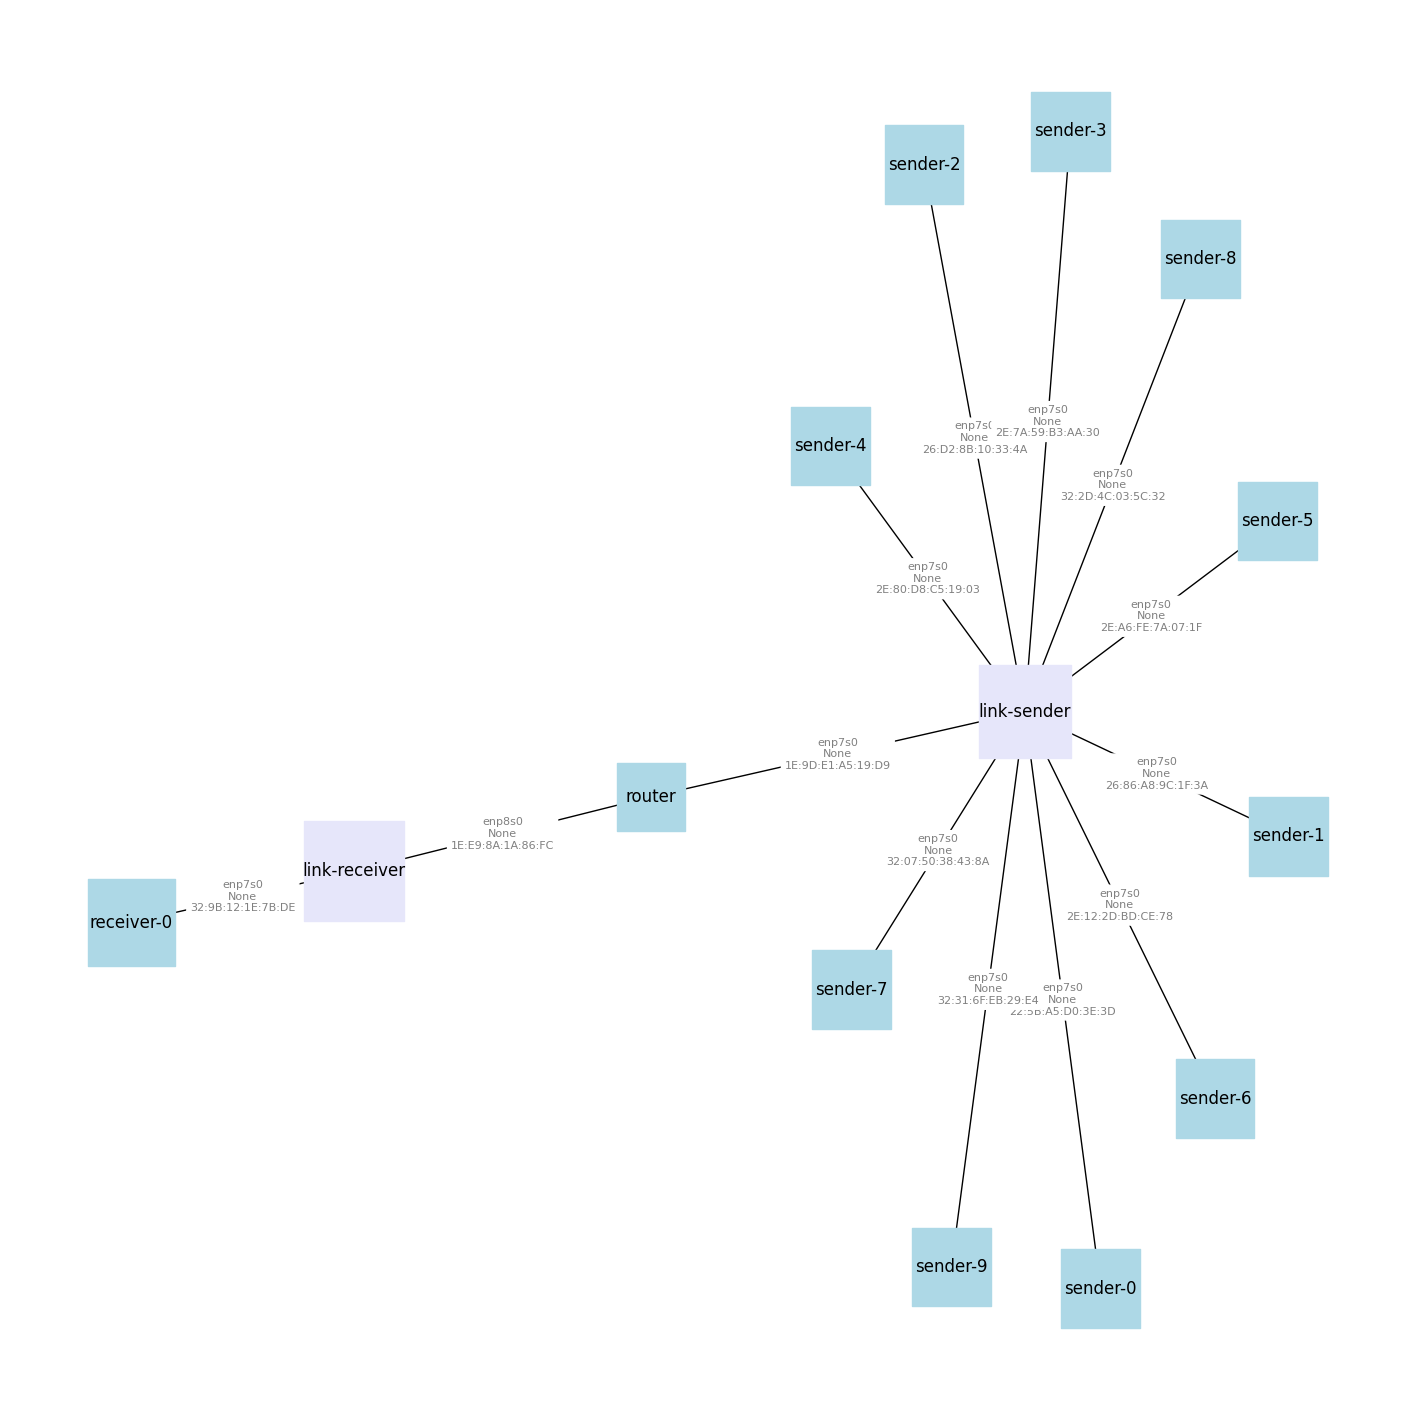

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(all_nodes),len(all_nodes)))
G = nx.Graph()
G.add_nodes_from(all_nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in all_nodes], 
        node_size=[len(n[0])*400 for n in all_nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);
     

## Extend your slice

In [14]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

## Log in to hosts

In [73]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
router,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe73:27e2
sender-0,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe67:38cb
sender-1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feb4:bdbb
sender-2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feaa:b754
sender-3,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe87:6044
sender-4,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fede:283c
sender-5,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:feab:b3eb
sender-6,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fec2:5140
sender-7,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe29:dd98


In [7]:
sender_nodes = [slice.get_node(name='sender-' + str(i))  for i in range(n_senders)]
receiver_nodes = [slice.get_node(name='receiver-' + str(i))  for i in range(n_receivers)]
router_node = slice.get_node(name='router')
router_ingress_iface = router_node.get_interface(network_name = "link-sender")
router_egress_iface  = router_node.get_interface(network_name = "link-receiver")
router_egress_name = router_egress_iface.get_device_name()

## Configure queues

In [122]:
import math

btl_rate = 100 # in Mbps

btl_link_delay = 10 # in ms

limit = math.ceil((1*btl_rate * btl_link_delay * 10^3)/8)

avpkt = 1000

print(limit)

print(math.ceil(limit*5/(36*avpkt)))


router_node.execute(f"sudo tc qdisc del dev {router_egress_name} root")
router_node.execute(f"sudo tc qdisc replace dev {router_egress_name} root handle 1: htb default 3")
router_node.execute(f"sudo tc class add dev {router_egress_name} parent 1: classid 1:3 htb rate {btl_rate}mbit")

router_node.execute(f"sudo tc qdisc add dev {router_egress_name} parent 1:3 handle 3: red limit {limit} max {limit} avpkt 1000 bandwidth {btl_rate}Mbit burst 1")

1251
1
 RED: failed to calculate EWMA constant.
 

('', 'RED: failed to calculate EWMA constant.\n')

In [22]:
import random
for n in sender_nodes:
    sender_inf = n.get_interface(network_name="link-sender")
    sender_inf_name = sender_inf.get_device_name()
    
    sender_delay = round(random.uniform(20,30),1)
    
    print(sender_delay)
    
    n.execute(f"sudo tc qdisc del dev {sender_inf_name} root")
    n.execute(f"sudo tc qdisc add dev {sender_inf_name} root netem delay {sender_delay}ms limit 1000000")
    # n.execute(f"sudo tc qdisc add dev {sender_inf_name} parent 1:1 handle 10: fq pacing")

23.4
20.6
20.3
21.1
24.3
27.2
27.9
25.3
24.2
27.3


### Execute Experiment

In [123]:
receiver_nodes[0].execute("rm -r scherrer-exp-aggregate")
router_node.execute("rm -r scherrer-exp-aggregate")

('', '')

In [8]:
for n in sender_nodes:
    n.execute("sudo modprobe tcp_bbr")
    n.execute("sudo modprobe tcp_bbr2")
    
for n in receiver_nodes:
    n.execute("sudo modprobe tcp_bbr")
    n.execute("sudo modprobe tcp_bbr2")

In [9]:
# Set experimental parameters : generate full factorial experiment
import itertools
exp_factors = {
    'rate': [100],
    'btl_delay': [10],
    'cca': ["bbr2-bbr2","bbr2-cubic","bbr2-reno"],
    'test_duration': [9],
    'flows': [1],
    'interval': [0.1],
    'omit': [4],
    'aqm': ['FIFO'],
    'buffer_factor' : [1,2,3,4,5,6,7],
    'trial': [1,2,3]
}

factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]

In [125]:
import os
import csv

os.remove('experiment_results.csv')
# Create a list of header fields for the CSV file
fields = ['rate', 'btl_delay', 'cca', 'test_duration', 'flows', 'interval', 'omit', 'aqm', 'buffer_factor', 'trial', 'jfi', 'loss_percentage', 'utilization', 'buffer_occupancy']

# Write the header to the CSV file
with open('experiment_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()

In [11]:
fields = ['rate', 'btl_delay', 'cca', 'test_duration', 'flows', 'interval', 'omit', 'aqm', 'buffer_factor', 'trial', 'jfi', 'loss_percentage', 'utilization', 'buffer_occupancy']

In [12]:
import time
import os
import csv
import random
import math
import itertools

router_script="rm queue.txt; start_time=$(date +%s); while true; do tc -p -s -d qdisc show dev {iface} | tr -d \'\n\' | ts '%.s' | tee -a queue.txt; echo \"\" | tee -a queue.txt; current_time=$(date +%s); elapsed_time=$((current_time - start_time));  if [ $elapsed_time -ge {duration} ]; then break; fi; sleep 0.01; done;"

def create_directory(directory_name):
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    else:
        print(f"Directory '{directory_name}' already exists.")
        
        
def setup_experiment(exp):
    directory_name = "scherrer-exp-aggregate"
    create_directory(directory_name)

    data_dir = os.path.join(os.getcwd(), directory_name)
    iequal_file_out = os.path.join(data_dir, f'ieq_{"_".join(str(v) for v in exp.values())}.csv')

    if os.path.exists(iequal_file_out):
        print("Already have relevant files, skipping")
        return

    print("Running experiment for exp:", iequal_file_out)
    
    limit = math.ceil(((exp['buffer_factor']+1)*exp['rate'] * exp['btl_delay'] * 10^3)/8)

    # Set up router queue
    
    router_node.execute(f"sudo tc qdisc del dev {router_egress_name} root")
    router_node.execute(f"sudo tc qdisc replace dev {router_egress_name} root handle 1: htb default 3")
    router_node.execute(f"sudo tc class add dev {router_egress_name} parent 1: classid 1:3 htb rate {exp['rate']}mbit")
    
    if exp['aqm'] == 'FIFO':
        router_node.execute(f"sudo tc qdisc add dev {router_egress_name} parent 1:3 handle 3: bfifo limit {limit}")
    if exp['aqm'] == 'RED':
        router_node.execute(f"sudo tc qdisc add dev {router_egress_name} parent 1:3 handle 3: red limit {limit} avpkt 1000 bandwidth {exp['rate']}Mbit")

    # Remove existing result files from hosts
        
    # Set up delay on receiver interface
    for n in receiver_nodes:
        receiver_inf = n.get_interface(network_name="link-receiver")
        receiver_inf_name = receiver_inf.get_device_name()
        n.execute(f"sudo tc qdisc del dev {receiver_inf_name} root netem")
        n.execute(f"sudo tc qdisc add dev {receiver_inf_name} root netem delay {exp['btl_delay']}ms limit 1000000")
        
        
    
        
def add_sender_link_delays(sender_nodes):
    for n in sender_nodes:
        sender_inf = n.get_interface(network_name="link-sender")
        sender_inf_name = sender_inf.get_device_name()

        sender_delay = round(random.uniform(20,30),1)

        #print(sender_delay)

        n.execute(f"sudo tc qdisc del dev {sender_inf_name} root")
        n.execute(f"sudo tc qdisc add dev {sender_inf_name} root netem delay {sender_delay}ms limit 1000000")
        # n.execute(f"sudo tc qdisc add dev {sender_inf_name} parent 1:1 handle 10: fq pacing")

        
def start_servers(sender_nodes, base_port):  
    for i,s in enumerate(sender_nodes):
        s.execute("sudo killall iperf3")
        
        server_port = base_port + i
        s.execute(f"iperf3 -s -D -p {server_port}")

def start_clients(receiver_node, sender_nodes, exp, base_port):
    print("Start parallel clients on the senders")
    
    r = receiver_node
    r.execute("rm *.json")
    r.execute("sudo killall iperf3")
    
    #print(router_script.format(iface=router_egress_name, duration=exp["test_duration"]))
    
    
    for i, n in enumerate(sender_nodes):
        
        server_port = base_port + i
        server_id = 10 + i
        
        cca = exp['cca'].split("-")[0] if i < 5 else exp['cca'].split("-")[1]
        
        #print(f'sleep 1; iperf3 -c 10.10.2.10 -t {exp["test_duration"]} -P {exp["flows"]} -C {cca} -p {server_port} -O {exp["omit"]} -i {exp["interval"]} -J > flow-{i}-result.json')

        r.execute_thread(f'sleep 1; iperf3 -c 10.10.1.{server_id} -t {exp["test_duration"]} -P {exp["flows"]} -C {cca} -p {server_port} -O {exp["omit"]} -i {exp["interval"]} -R -J > flow-{i}-result.json')
        
    router_node.execute_thread(router_script.format(iface=router_egress_name, duration=exp["test_duration"]))
    
def copy_files_to_dir(exp_dir):   
    
    receiver_nodes[0].execute(f'mkdir -p {exp_dir} && mv *.json {exp_dir}/')
    
    router_node.execute(f'mkdir -p {exp_dir} && mv *.txt {exp_dir}/')
    
    router_node.execute(f'mkdir -p {exp_dir} && mv *.csv {exp_dir}/')
        
def compute_jfi(throughput):

    #mean_throughput = sum(throughput) / len(throughput)

    denominator = sum(t ** 2 for t in throughput)
    
    numerator = (sum(throughput)) ** 2
    
    jfi = (numerator / (len(throughput) * denominator))
    
    return jfi
        
def process_data(receiver_node, sender_nodes, exp):
    
    r = receiver_node
    
    sum_tput = 0
    
    pkt_loss = 0
    
    throughput = []
    for i,s in enumerate(sender_nodes):
        
        sum_received, stderr = r.execute(f'echo $(jq \'.end.sum_received.bits_per_second\' \"flow-{i}-result.json\")')
        
        throughput.append(float(sum_received))
        
        retrans, stderr = r.execute(f'echo $(jq \'.end.streams[].sender.retransmits\' \"flow-{i}-result.json\")')
        
        retrans = float(retrans)
        pkt_loss = pkt_loss + retrans
        
    loss_percentage = ((pkt_loss * 1500 * 8) * 100) / (sum(throughput) * exp['test_duration'])
    
    utilization = (sum(throughput) * 100)/ (exp['rate'] * 1000000)
        
    jfi = compute_jfi(throughput)
    
    
    router_node.execute("cat queue.txt | awk '{{print $1\",\"$24$30\",\"$31}}' | tr -d 'b' | tr -d 'p' | sed 's/K/000/' | sed 's/M/000000/' > queue.csv")
    
    mean_backlog, stderr = router_node.execute("echo $(awk -F ',' '{ total += $3; count++ } END { print total/count }' \"queue.csv\")")
    
    limit = math.ceil(((exp['buffer_factor']+1)*exp['rate'] * exp['btl_delay'] * 10^3)/8)
    
    buffer_occupancy = (float(mean_backlog) * 100)/limit
    
    
#     print("Jain's fairness index = ", jfi)
    
#     print("Loss percentage = ", loss_percentage)
    
#     print("Utilization = ", utilization)
    
#     print("Buffer occupancy percentage = ", buffer_occupancy)
    
    row = {**exp, 'jfi': jfi, 'loss_percentage': loss_percentage, 'utilization': utilization, 'buffer_occupancy': buffer_occupancy}
    with open('experiment_results.csv', mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fields)
        writer.writerow(row)

        
    
for exp in exp_lists:
    
    setup_experiment(exp)
    
    add_sender_link_delays(sender_nodes)
    
    base_port = 5201

    # Start servers
    start_servers(sender_nodes, base_port)
    
    # Start clients
    start_clients(receiver_nodes[0], sender_nodes, exp, base_port)
    
    time.sleep(exp['test_duration'] + 10)
    
    
    process_data(receiver_nodes[0], sender_nodes, exp)
    
    
    # Copy files to directory
    exp_dir = f"scherrer-exp-aggregate/{'_'.join(str(v) for v in exp.values())}"
    copy_files_to_dir(exp_dir)



Directory 'scherrer-exp-aggregate' already exists.
Running experiment for exp: /home/fabric/work/bbr_imc_2022/scherrer-exp-aggregate/ieq_100_10_bbr2-bbr2_9_1_0.1_4_FIFO_1_1.csv
Start parallel clients on the senders
 iperf3: no process found
 1737596.910938825
76
3467483.112471854
121
1901062.2661945482
60
2764717.4313840983
105
2709366.17952271
104
1827695.9500818276
83
2433928.192856975
97
1836724.4942370025
67
1812253.4512519173
62
1843144.135080075
74
18.866
Directory 'scherrer-exp-aggregate' already exists.
Running experiment for exp: /home/fabric/work/bbr_imc_2022/scherrer-exp-aggregate/ieq_100_10_bbr2-bbr2_9_1_0.1_4_FIFO_1_2.csv
Start parallel clients on the senders
 rm: cannot remove '*.json': No such file or directory
  iperf3: no process found
 1489187.8864861971
57
1876605.914882317
86
3367086.033752701
109
2010467.3321702967
63
2132745.243856355
71
1616610.6574385236
53
2010467.1087850868
74
1929383.4143223844
85
2939760.471217568
115
1617894.8915785863
75
48.9968
Directory 

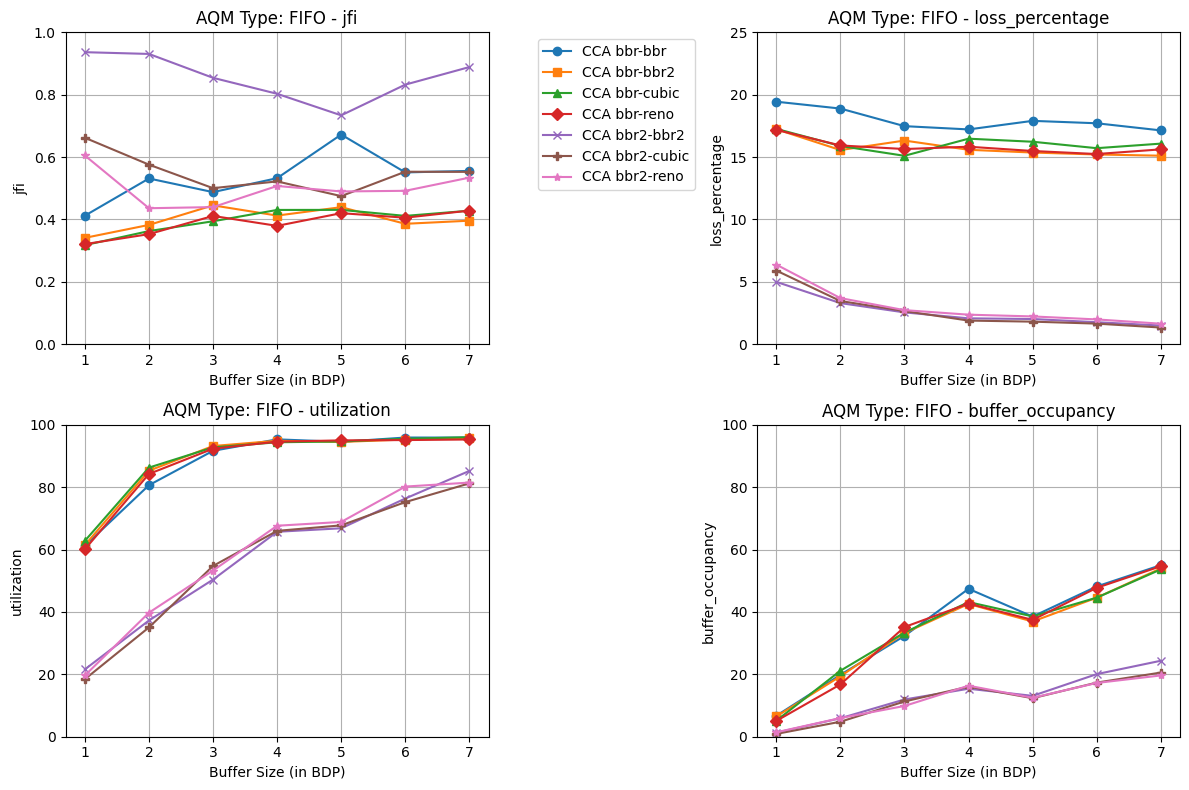

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
data = pd.read_csv('experiment_results.csv')

# Group data by 'aqm' column
grouped_by_aqm = data.groupby('aqm')

# Define the metrics you want to plot
metrics = ['jfi', 'loss_percentage', 'utilization', 'buffer_occupancy']

# Define markers for each CCA combination
markers = ['o', 's', '^', 'D', 'x', 'P', '*', 'v', '<', '>']

# Create subplots with 2 columns
num_metrics = len(metrics)
num_rows = num_metrics // 2 + num_metrics % 2  # Adjust for odd number of metrics
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through each AQM type
for aqm, aqm_group in grouped_by_aqm:
    # Iterate through each metric
    for idx, metric in enumerate(metrics):
        ax = axes[idx]  # Select the current subplot
        
        ax.set_title(f"AQM Type: {aqm} - {metric}")
        ax.set_xlabel('Buffer Size (in BDP)')
        ax.set_ylabel(metric)
        
        # Group data by 'cca' column
        grouped_data = aqm_group.groupby('cca')
        
        # Iterate through each CCA combination
        for i, (cca, group) in enumerate(grouped_data):
            # Group data by 'buffer_factor' and calculate the mean for each group
            mean_data = group.groupby('buffer_factor')[metric].mean()
            
            # Plot the data for this CCA combination with marker
            ax.plot(mean_data.index, mean_data.values, marker=markers[i % len(markers)], label=f'CCA {cca}')
        
        # Set Y limits for each metric
        if metric == 'jfi':
            ax.set_ylim(0, 1)
        elif metric == 'loss_percentage':
            ax.set_ylim(0, 25)
        elif metric == 'utilization' or metric == 'buffer_occupancy':
            ax.set_ylim(0, 100)
    
        ax.grid(True)

# Create a single legend for all subplots on the right side
axes[0].legend(bbox_to_anchor=(1.1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Save plots to PDF
plt.savefig('experiment_results.pdf', format='pdf')

plt.show()
